
## Task 2
Create a PowerPoint presentation wihch outlines the approach we will be taking to identify which of the 1000 customers Sprocket Central Pty Ltd should target, based on this dataset. Explain the three phases:  Data Exploration; Model Development and Interpretation.


Sprocket Central Pty Ltd has given us a new list of 1000 potential customers with their demographics and attributes. However, these customers do not have prior transaction history with the organisation. 

The marketing team at Sprocket Central Pty Ltd is sure that, if correctly analysed, the data would reveal useful customer insights which could help optimise resource allocation for targeted marketing. Hence, improve performance by focusing on high value customers.



For context, Sprocket Central Pty Ltd is a long-standing KPMG client whom specialises in high-quality bikes and accessible cycling accessories to riders. Their marketing team is looking to boost business by analysing their existing customer dataset to determine customer trends and behaviour. 

Using the existing 3 datasets (Customer demographic, customer address and transactions) as a labelled dataset, please recommend which of these 1000 new customers should be targeted to drive the most value for the organisation. 

In building this recommendation, we need to start with a PowerPoint presentation which outlines the approach which we will be taking. The client has agreed on a 3 week scope with the following 3 phases as follows - Data Exploration; Model Development and Interpretation.

Prepare a detailed approach for completing the analysis including activities – i.e. understanding the data distributions, feature engineering, data transformations, modelling, results interpretation and reporting. This detailed plan needs to be presented to the client to get a sign-off. Please advise what steps you would take. 

Please ensure your PowerPoint presentation includes a detailed approach for our strategy behind each of the 3 phases including activities involved in each - i.e. understanding the data distributions, feature engineering, data transformations, modelling, results interpretation and reporting. This detailed plan needs to be presented to the client to get a sign-off.

--
Tips: Raw data fields may be transformed into other calculated fields for modelling purposes (i.e. converting D.O.B to age or age groups).  Tips: You may source external data from the ABS / Census to add additional variables that may help support your model.


#### list_price : The list price, also known as the manufacturer's suggested retail price (MSRP), or the recommended retail price (RRP)
#### standard_cost :Standard costs are estimates of the actual costs in a company's production process, because actual costs cannot be known in advance.

#### clustering customers by the buisness value they generate

## Objectives

##### 1) Find high value customers
##### 2) Determine customer trends and behaviour
##### 3) which of these 1000 new customers should be targeted to drive the most value for the organisation
##### 4) Data Exploration; Model Development and Interpretation- PPT on the project approach(understanding the data distributions, feature engineering, data transformations, modelling, results interpretation and reporting)

##### can customers be clustered based on their value?


In [1]:
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sns 
from datetime import date
import numpy as np


import DataReporter
%run -i DataReporter.py
import warnings
warnings.filterwarnings('ignore')

In [2]:
excelFile = pd.ExcelFile("newData.xlsx")   

In [3]:
Transactions = pd.read_excel(excelFile, 'Transactions', skiprows=[0]) 
CustomerDemographic = pd.read_excel(excelFile,'CustomerDemographic', skiprows=[0]) 
CustomerAddress = pd.read_excel(excelFile, 'CustomerAddress', skiprows=[0])
newCustomers = pd.read_excel(excelFile,"NewCustomerList", skiprows = [0])
pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows",None) 

In [4]:
df = pd.merge(CustomerDemographic,CustomerAddress, on="customer_id")  
df = pd.merge(Transactions,df, on="customer_id") 

In [5]:
df = df.drop(axis=1,columns=["default","country"])

### Correcting the values in the column's gender and state. Values are represented consistently

In [6]:
filt = (df["gender"] == "Femal") | (df["gender"] == "Female")
df.loc[filt,"gender"] = "F"
filt = (df["gender"] == "Male")
df.loc[filt,"gender"] = "M"

In [7]:
filt = (df["state"] == "Victoria")
df.loc[filt,"state"] = "VIC"
filt = (df["state"] == "New South Wales")
df.loc[filt,"state"] = "NSW"

## Deriving new features

In [8]:
df['transaction_month'] = pd.DatetimeIndex(df['transaction_date']).month
df["profitMargin"] = df.apply(lambda x: x["list_price"] - x["standard_cost"], axis = 1)
df['age'] = (pd.Timestamp("now") - df['DOB']).astype('<m8[Y]') 

### Removing Outliers in age, cancelled transactions

In [9]:
df = df[df['age'] < 100]
df = df[df["order_status"] == "Approved"]  # removing cancelled transactions

## Quick data exploration

In [10]:
import DataReporter
%run -i DataReporter.py
report = Report(df)

In [11]:
report.eda()

 Size of the data set is (19337, 31) 


column:  transaction_id
Number of Unique values: 19337
min = 1, max = 20000, range = 19999

column:  product_id
Number of Unique values: 101
min = 0, max = 100, range = 100

column:  customer_id
Number of Unique values: 3411
min = 1, max = 3500, range = 3499

column:  transaction_date
Number of Unique values: 364
min = 2017-01-01 00:00:00, max = 2017-12-30 00:00:00, range = 363 days 00:00:00

column:  online_order
Number of Unique values: 3
min = 0.0, max = 1.0, range = 1.0
List
 [ 0.  1. nan]

column:  order_status
order_status  has zero variance

column:  brand
Number of Unique values: 7
List
 ['Solex' 'Giant Bicycles' 'Trek Bicycles' 'WeareA2B' 'OHM Cycles'
 'Norco Bicycles' nan]

column:  product_line
Number of Unique values: 5
List
 ['Standard' 'Road' 'Touring' 'Mountain' nan]

column:  product_class
Number of Unique values: 4
List
 ['medium' 'high' 'low' nan]

column:  product_size
Number of Unique values: 4
List
 ['medium' 'large' 'small' 

## missing values

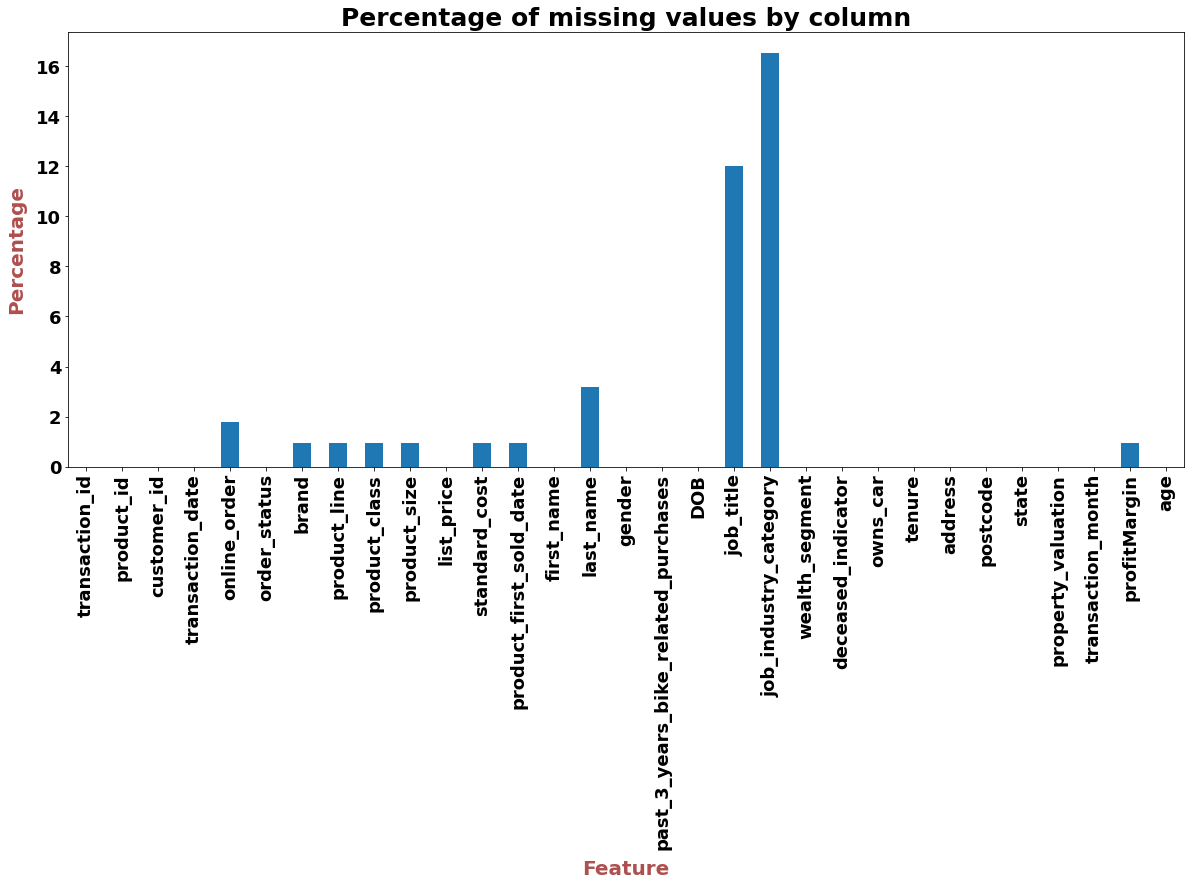

In [12]:
#plt.style.use('fivethirtyeight')
report.missing()

1) The 'job_industry_category' column has about 16% of the values missing and it is better to be removed.  <br />
<br />
2) The missing values in many columns can be removed by just dropoing the rows containing null values. An alternative could be to reduce the missing values in a column by taking it value from other rows containing similar records. <br />
<br />
3) For retaining as much information as possible its first better to identify unwanted columns  remove them before droping unwanted rows. possible imputation techniques may also be explored


#### very common and useful customer segmentation methods include categorization through ("Recency","Frequency","Monetory Value") <br />
https://towardsdatascience.com/data-driven-growth-with-python-part-2-customer-segmentation-5c019d150444   
<br />
Recency:  To find out about recency we need to find the number of days a customer is inactive for

In [13]:
today = str(date.today())
last_transaction = df["transaction_date"].max()   # most recent customer transaction
df["Recency"] = last_transaction - df["transaction_date"] 
df['Recency'] = df['Recency'].dt.days.astype('int64')

#### Recency is the number of days of customer inactivity. It is calulated with respect to the recent transaction date 

In [14]:
copyDF = df.copy()

In [15]:
df_recency = df.groupby("customer_id")[["Recency"]].min()
df_recency = df_recency.reset_index()
df_recency["Recency"].describe()['mean']

61.52037525652301

<AxesSubplot:xlabel='Recency', ylabel='Count'>

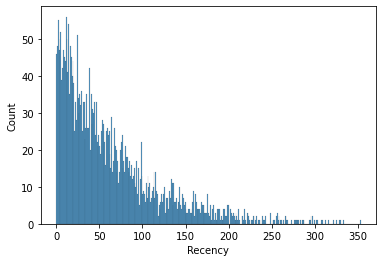

In [16]:
sns.histplot(data = df_recency, x = "Recency",binwidth = 1)

##### 1) The above histogram indicates most of the customers have purchased within last 100 days. <br />  <br />2) There are also customers who havent made any transaction in the past three months. On an average customers are visiting after a period of two months

In [17]:
# K - means
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

<AxesSubplot:xlabel='Recency'>

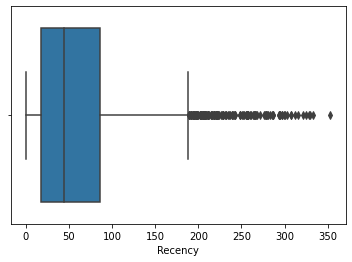

In [18]:
sns.boxplot(x=df_recency["Recency"])

In [19]:
wcss = {}

for k in range(2,40):
    model = KMeans(n_clusters = k, init = "k-means++", n_init = 10, max_iter = 500)
    pipe = Pipeline(steps = [('k_means',model)])
    km = pipe.fit(df_recency[["Recency"]])
    wcss[k] = km["k_means"].inertia_

<AxesSubplot:>

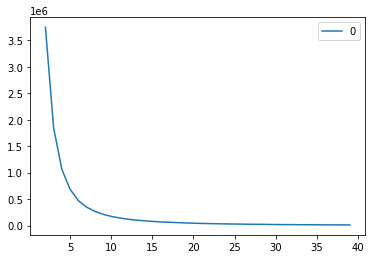

In [20]:
wcssDF = pd.DataFrame.from_dict(wcss, orient = "index")
wcssDF.plot()

In [21]:
# seems that 5 or 6 clusters is a good 
k = 4     # k = 4 means 5 clusters
model = KMeans(n_clusters = k, init = "k-means++", n_init = 10, max_iter = 800, random_state = 111)
pipe = Pipeline(steps = [("k_means",model)])
km = pipe.fit(df_recency[["Recency"]])
labels = km["k_means"].labels_
centroids = km["k_means"].cluster_centers_

In [22]:
np.unique(labels)

array([0, 1, 2, 3])

In [23]:
df_recency["recency_cluster"] = labels
# df_recency["RecencyGroup"] = km.predict(df_recency[["Recency"]]) can be done this way as well

In [24]:
#df["RecencyGroup"] = km.predict(df[["Recency"]]) # this will add cluster label to the original data frame but repeating customers will belong to different clusters based on the transaction date. For consistency we need to modity this but we will see it later if needed
df_recency.groupby("recency_cluster")["Recency"].describe()

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,1052.0,69.496198,16.298622,45.0,55.0,67.0,82.0,103.0
1,1715.0,19.558601,12.902038,0.0,9.0,18.0,30.0,44.0
2,158.0,232.778481,39.947517,185.0,199.0,221.0,258.0,353.0
3,486.0,136.654321,22.524760,104.0,116.0,134.0,155.0,184.0


#### cluster 1 contains very recent customers
#### cluster 0 contains recent customers
#### cluster 4 contains customers who are at risk of churn
#### cluster 2 contains customers who are at very high risk of churn
next we need to focus on customer frequency and customer total spending. TO identify most valuable customers we need we need to similarly cluster them through frequency and total spending and score them according to the values. The most valuable customers are the ones with higher values in the three variables. For minimizing churn one has to identify the less recent customers who have high values of frequency or/and spending for targeting and retaining them back. Later we will model customer churn through random forest survival methods

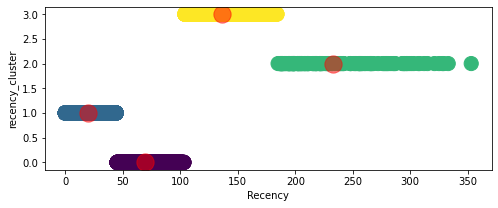

In [25]:
plt.figure(1, figsize = (8,3))
column1, column2 = "Recency", "recency_cluster"
plt.scatter( x = column1 ,y = column2 , data = df_recency , c = labels , s = 200 )
plt.scatter(x = centroids[: , 0], y =[0,1,2,3], s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel(column2) , plt.xlabel(column1)
plt.show()

#### Frequency

In [26]:
df_frequency = df.groupby("customer_id")[["transaction_id"]].count().reset_index()
df_frequency.rename(columns = {"transaction_id" : "frequency"}, inplace = True)
df_frequency.head()

,customer_id,frequency
0,1,11
1,2,3
2,4,2
3,5,6
4,6,5


In [27]:
df = pd.merge(df,df_frequency,on = "customer_id")   # biger dataset, smaller dataset, merge on left-join which is the default

5.6690120199355025

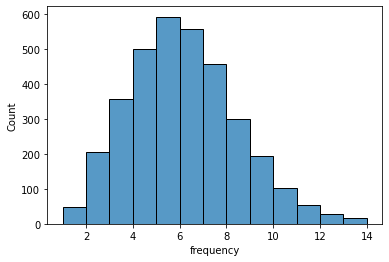

In [28]:
sns.histplot(data = df_frequency, x = "frequency",binwidth =1)
df_frequency["frequency"].describe()['mean']

<AxesSubplot:>

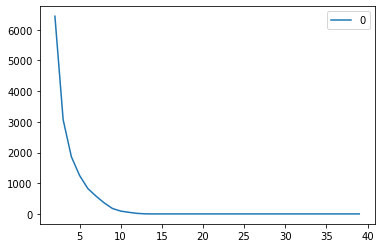

In [29]:
wcss = {}
for k in range(2,40):
    model = KMeans(n_clusters = k, init = "k-means++", n_init = 10, max_iter = 500)
    pipe = Pipeline(steps = [("k_means", model)])
    km = pipe.fit(df_frequency[["frequency"]])
    wcss[k] = km["k_means"].inertia_
wcssDF = pd.DataFrame.from_dict(wcss, orient = "index")
wcssDF.plot()

In [30]:
k = 4     # k = 4 means 5 clusters
model = KMeans(n_clusters = k, init = "k-means++", n_init = 10, max_iter = 800, random_state = 111)
pipe = Pipeline(steps = [("k_means",model)])
km = pipe.fit(df_frequency[["frequency"]])
labels = km["k_means"].labels_
centroids = km["k_means"].cluster_centers_
df_frequency["frequency_cluster"] = labels

In [31]:
df_frequency.groupby("frequency_cluster")["frequency"].describe()[["mean"]]

,mean
frequency_cluster,
0,6.804265
1,2.504902
2,9.923858
3,4.542125


### monetory

In [32]:
df_monetory = df.groupby("customer_id")[["profitMargin"]].sum().reset_index() # customers who buy products that deliver higher profits
df_monetory.rename(columns = {"profitMargin" : "TotalProfits"}, inplace = True)

In [33]:
df_monetory["TotalProfits"].describe()['mean']

3091.650732922896

<AxesSubplot:>

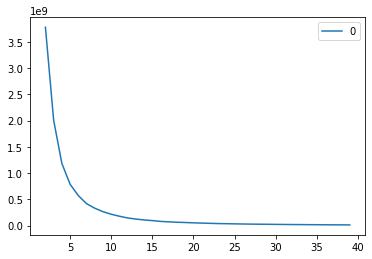

In [34]:
wcss = {}
for k in range(2,40):
    model = KMeans(n_clusters = k, init = "k-means++", n_init = 10, max_iter = 500)
    pipe = Pipeline(steps = [("k_means", model)])
    km = pipe.fit(df_monetory[["TotalProfits"]])
    wcss[k] = km["k_means"].inertia_
wcssDF = pd.DataFrame.from_dict(wcss, orient = "index")
wcssDF.plot()

In [35]:
k=4
model = KMeans(n_clusters = k, init = "k-means++", n_init = 10, max_iter = 800, random_state = 111)
pipe = Pipeline(steps = [("k_means",model)])
km = pipe.fit(df_monetory[["TotalProfits"]])
labels = km["k_means"].labels_
centroids = km["k_means"].cluster_centers_
df_monetory["profit_cluster"] = labels        #df_monetory[["TotalProfits"]]

In [36]:
df_monetory.groupby("profit_cluster")["TotalProfits"].describe()[["mean"]]

,mean
profit_cluster,
0,4550.452654
1,1188.193642
2,2788.881607
3,6936.939669


In [37]:
df_monetory.shape

(3411, 3)

In [38]:
df_frequency.shape

(3411, 3)

In [39]:
df_recency.shape
df_monetory.head()

,customer_id,TotalProfits,profit_cluster
0,1,3018.09,2
1,2,2226.26,2
2,4,220.57,1
3,5,2394.94,2
4,6,3946.55,0


In [40]:
df_rfm = pd.merge(df_recency[["customer_id","Recency"]],df_frequency[["customer_id","frequency"]], on ="customer_id")
df_rfm = pd.merge(df_rfm,df_monetory[["customer_id","TotalProfits"]])
df_rfm.head()

,customer_id,Recency,frequency,TotalProfits
0,1,7,11,3018.09
1,2,128,3,2226.26
2,4,195,2,220.57
3,5,16,6,2394.94
4,6,64,5,3946.55


In [41]:
def func(x):
    return x/x.max()

df_rfm[["Recency","frequency","TotalProfits"]] = df_rfm[["Recency","frequency","TotalProfits"]].apply(func,axis = 0)

In [42]:
df_rfm.head()

,customer_id,Recency,frequency,TotalProfits
0,1,0.019830,0.785714,0.258643
1,2,0.362606,0.214286,0.190785
2,4,0.552408,0.142857,0.018902
3,5,0.045326,0.428571,0.205240
4,6,0.181303,0.357143,0.338210


<AxesSubplot:>

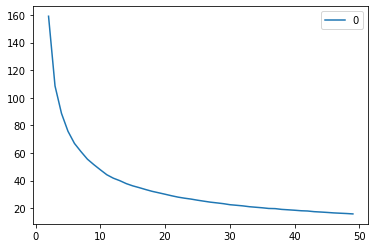

In [43]:
wcss = {}
for k in range(2,50):
    model = KMeans(n_clusters = k, init = "k-means++", n_init = 10, max_iter = 500)
    pipe = Pipeline(steps = [("k_means", model)])
    km = pipe.fit(df_rfm.drop(axis=1, columns=["customer_id"]))
    wcss[k] = km["k_means"].inertia_
wcssDF = pd.DataFrame.from_dict(wcss, orient = "index")
wcssDF.plot()

In [44]:
k=4
model = KMeans(n_clusters = k, init = "k-means++", n_init = 10, max_iter = 8000, random_state = 111)
pipe = Pipeline(steps = [("k_means",model)])
km = pipe.fit(df_rfm.drop(axis=1, columns=["customer_id"]))
centroids = km["k_means"].cluster_centers_
# labels = km["k_means"].labels_
# df_rfm["labels"] = labels 
df_rfm["clusters"] = km.predict(df_rfm[["Recency","frequency","TotalProfits"]])

In [45]:
df_rfm.head()

,customer_id,Recency,frequency,TotalProfits,clusters
0,1,0.019830,0.785714,0.258643,2
1,2,0.362606,0.214286,0.190785,1
2,4,0.552408,0.142857,0.018902,1
3,5,0.045326,0.428571,0.205240,0
4,6,0.181303,0.357143,0.338210,0


In [92]:
df_rfm.groupby("clusters").mean()
#grp.describe()
#grp.iloc[:, grp.columns.get_level_values(0)=='Recency']#.reset_index()

,customer_id,Recency,frequency,TotalProfits
clusters,,,,
0,1716.225197,0.126917,0.464961,0.301684
1,1750.666667,0.483206,0.256506,0.154432
2,1746.643253,0.093479,0.652891,0.499957
3,1795.912362,0.123039,0.281497,0.157225


### visualizing the cluster in 2D

<AxesSubplot:xlabel='Recency', ylabel='TotalProfits'>

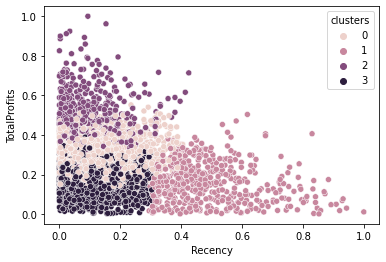

In [57]:
sns.scatterplot(data=df_rfm, x="Recency",y="TotalProfits", hue = "clusters")

In [93]:
### cluster 2 are most resent and can deliver higher profits

<AxesSubplot:xlabel='frequency', ylabel='TotalProfits'>

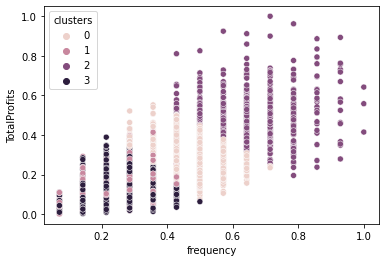

In [94]:
sns.scatterplot(data=df_rfm, x="frequency",y="TotalProfits", hue = "clusters")

<AxesSubplot:xlabel='frequency', ylabel='Recency'>

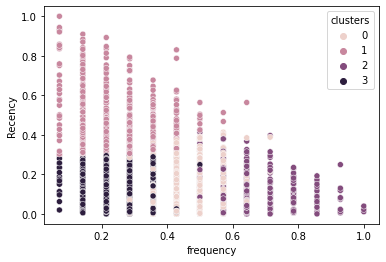

In [95]:
sns.scatterplot(data=df_rfm, x="frequency",y="Recency", hue = "clusters")

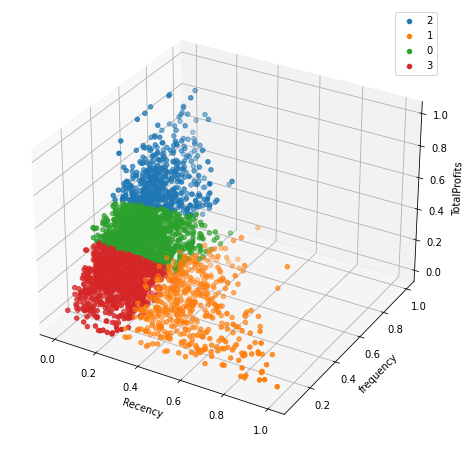

In [114]:
from matplotlib import cm
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

for cluster in df_rfm["clusters"].unique():
    ax.scatter(df_rfm.Recency[df_rfm.clusters==cluster],df_rfm.frequency[df_rfm.clusters==cluster],df_rfm.TotalProfits[df_rfm.clusters==cluster],label=cluster)

ax.set_xlabel('Recency')
ax.set_ylabel('frequency')
ax.set_zlabel('TotalProfits')    
ax.legend()

#### From the above three plots we can see that clients belonging to cluster 2 are high valued clients as they are more recent, frequent and purchace the products that deliver more profits. 

#### cluster3(shown black) are very recent but not frequent. This coluld be because they are new customers or the old ones that are at the risk of churn. In any case efforts should be put 

In [116]:
bestCustomers = df_rfm[df_rfm["clusters"] == 2]  # more recent, frequent and profitable

In [117]:
bestCustomers.head()

,customer_id,Recency,frequency,TotalProfits,clusters
0,1,0.019830,0.785714,0.258643,2
6,8,0.062323,0.714286,0.605619,2
20,25,0.014164,0.857143,0.457081,2
24,29,0.062323,0.642857,0.529208,2
31,37,0.019830,0.642857,0.543193,2


In [48]:
# groupby = ["brand","product_id","customer_id","online_order","brand","product_line","product_class","product_size","gender","job_industry_category","job_title","wealth_segment","owns_car","tenure","state","property_valuation"]
# measures = ["profit"]
# for group in groupby:
#     for measure in measures:
#         report.groupByPlot(group,measure)

In [49]:
# df.head()

In [50]:
# plt.figure(figsize=(15,5))
# sns.relplot(x=column1,y=column2,data=df, height = 5,aspect = 3)

In [51]:
# pp= df[["gender","age","past_3_years_bike_related_purchases","job_title","owns_car","tenure","state","property_valuation","profitMargin"]]
# sns.pairplot(pp)

In [52]:
#data.groupby(["customer_id"])["profit"].sum().sort_values(ascending = False)       # 3489

In [53]:
#df = df[["transaction_id","product_id","customer_id","online_order","order_status","brand","product_line","product_class","product_size","gender","past_3_years_bike_related_purchases","DOB","job_title","job_industry_category","wealth_segment","deceased_indicator","owns_car","tenure","state","property_valuation","transaction_month","profit"]]

In [54]:
#report.univarDist()